In [4]:
import matplotlib
matplotlib.use('nbagg')
# %matplotlib notebook
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy import signal, integrate
import matplotlib.pyplot as plt
import sys

import logging
logging.basicConfig(level=logging.INFO)

sys.path.append('/usr/local/lib/python3.5/site-packages')
sys.path.append('/home/gaspar/git/fm_fhss/')
from fm_fhss.fhss_simulator import FHSSSim
from fm_fhss import util
from fm_fhss import *
# from taranis_detector.main import TaranisPipeline

import time
import zmq
import random
import numpy as np

from src.blade_driver import BladeDriver, mixer
from scipy.signal import decimate, resample, resample_poly
import scipy
from struct import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
iq = scipy.fromfile(open('/home/gaspar/git/fm_fhss/phantom2/uksetaga_f2405350000.00_fs2181818.18_rx6_30_0_band2000000.00.iq'), dtype=scipy.complex64)
print(iq)

[-0.00032015+0.0006084j  -0.00276156+0.0006084j   0.00016813+0.00109668j
 ...,  0.00212125+0.0006084j   0.00065641-0.00036816j
  0.00016813+0.00012012j]


In [63]:
from numpy import complex, sum, abs, pi, arange, array, size, shape, real, sqrt
from numpy import matrix, sqrt, sum, zeros, concatenate, sinc
from numpy.random import randn, seed, random
def awgn(input_signal, snr_dB, rate=1.0):
    """
    Addditive White Gaussian Noise (AWGN) Channel.
    Parameters
    ----------
    input_signal : 1D ndarray of floats
        Input signal to the channel.
    snr_dB : float
        Output SNR required in dB.
    rate : float
        Rate of the a FEC code used if any, otherwise 1.
    Returns
    -------
    output_signal : 1D ndarray of floats
        Output signal from the channel with the specified SNR.
    """

    avg_energy = sum(abs(input_signal) * abs(input_signal))/len(input_signal)
    snr_linear = 10**(snr_dB/10.0)
    noise_variance = avg_energy/(2*rate*snr_linear)

    noise = (sqrt(noise_variance) * randn(len(input_signal))) + (sqrt(noise_variance) * randn(len(input_signal))*1j)

    output_signal = input_signal + noise

    return output_signal

Cut one packet
========

In [162]:
iq = scipy.fromfile(open('/home/gaspar/git/fm_fhss/phantom2/uksetaga_f2405350000.00_fs2181818.18_rx6_30_0_band2000000.00.iq'), dtype=scipy.complex64)
iq = iq[500000:507000]
# iq = awgn(iq, 10)

<IPython.core.display.Javascript object>


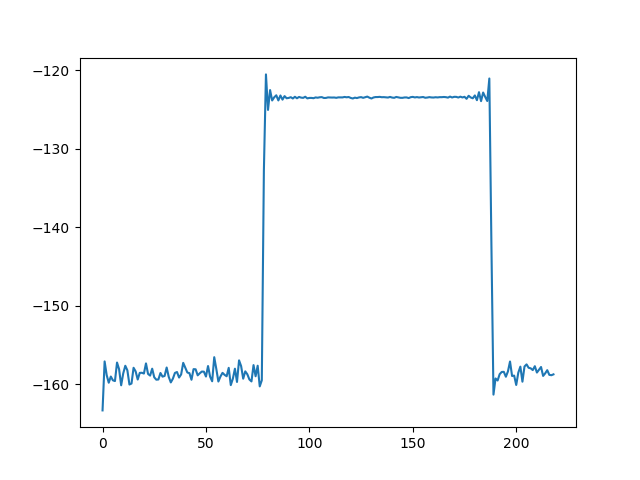

[  2.05234301e-08 +7.42676320e-08j   2.05234301e-08 +7.42676320e-08j
   2.05234301e-08 -1.64150947e-07j ...,   8.01280748e-08 -4.49416575e-08j
   2.05234301e-08 +7.42676320e-08j   2.05234301e-08 -4.49416575e-08j]


In [171]:
iq = scipy.fromfile(open('/home/gaspar/git/fm_fhss/phantom2/uksetaga_f2405350000.00_fs2181818.18_rx6_30_0_band2000000.00.iq'), dtype=scipy.complex64)
iq = iq[500000:507000]
# iq = awgn(iq, 10)

iq /= 2048 * 2 * 2
# https://se.mathworks.com/help/dsp/ref/dbconversion.html
# 10*log10(abs(u)^2/R) + 30
dbm = 10*np.log10(abs(iq)**2/50) + 30 # 50 is ohms

dbm -= 6 + 30 # compensate for bladeRF GAINS
dbm = decimate(dbm, 32, zero_phase=True)
plt.plot(dbm)
plt.show()
print(iq)

<IPython.core.display.Javascript object>


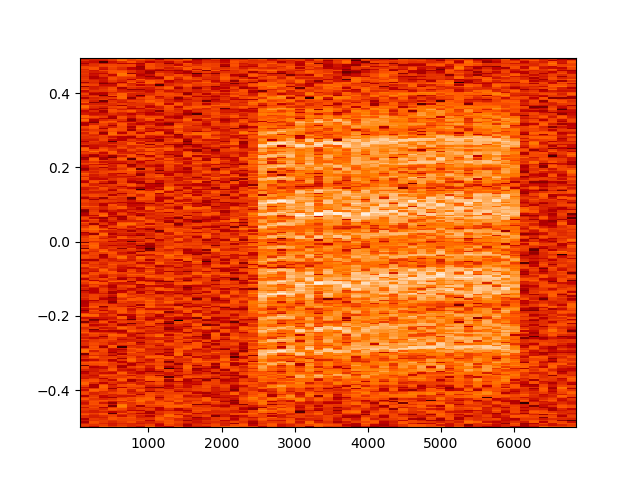

In [153]:
Pxx, freqs, bins, im = plt.specgram(iq, cmap=plt.cm.gist_heat, Fs= 1.0)
plt.show()

<IPython.core.display.Javascript object>


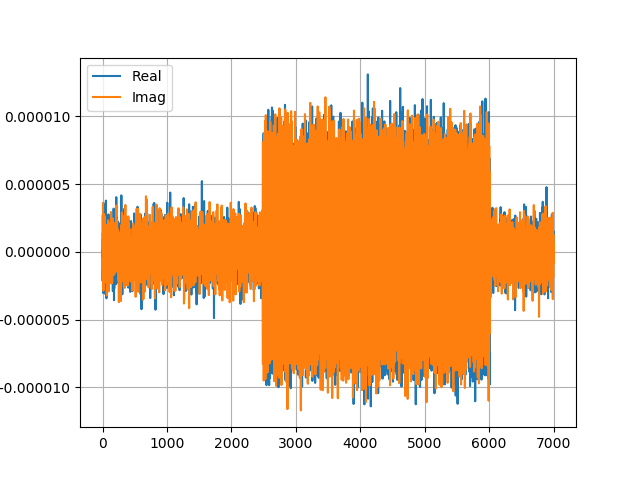

In [154]:
iqs = iq
plt.plot(iqs.real, label='Real')
plt.plot(iqs.imag, label='Imag')
plt.legend()
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


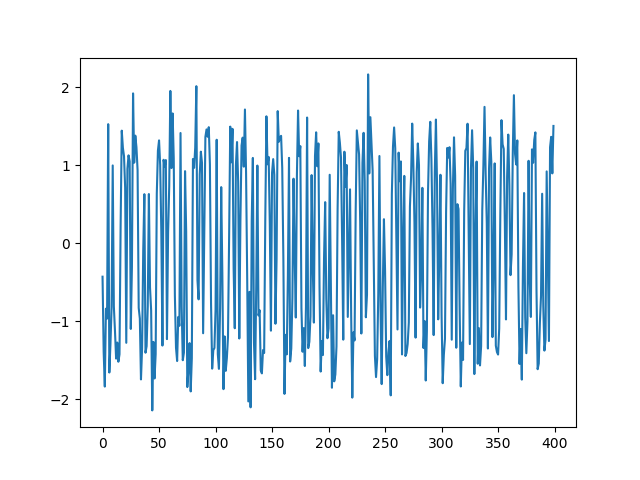

In [155]:
sl = slice(2800,3200)
demod = np.angle(iq[1:] * np.conjugate(iq[:-1]))
plt.plot(demod[sl])
plt.show()

<IPython.core.display.Javascript object>


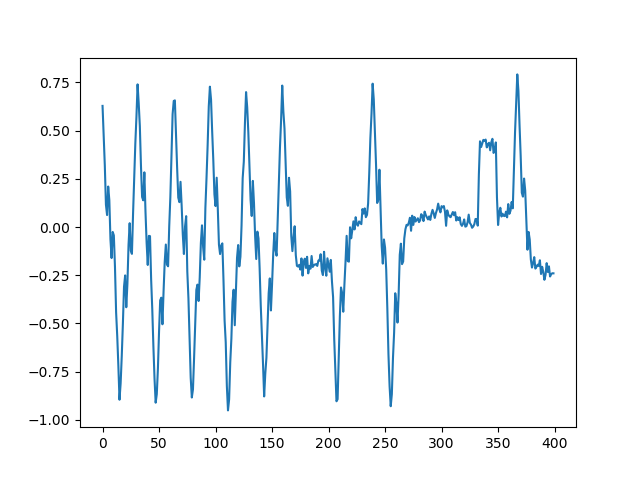

In [92]:
filter_length = 16
taps = [1 / filter_length] * filter_length
mavg = np.convolve(demod, taps)

plt.plot(mavg[sl])
plt.show()